# Histopathologic Cancer Detection
As is indicated by the title, the problem in this project is to identify histopathologic cancer from images. Let's start by looking at the data. Some steps like parameter tuning and submission file production might be simplified due to restrictions of performances of Kaggle.

Let's start by importing the data and visualizing it.

In [1]:
import numpy as np
import pandas as pd

# 220025 entries
# file name and label
df1 = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df1.head())
print(df1.info())

print(df1['label'].unique())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
[0 1]


As is shown from the basic analysis above, there are 220025 entries in the table, which contains two columns, i.e. id (file name) and a boolean label. The label can be 0 and 1. We can also show one sample image to have an idea about how the images look like.

(96, 96, 3)


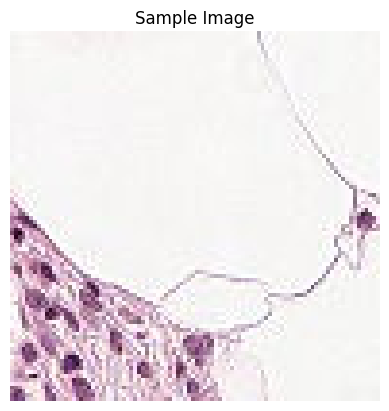

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# Visualize one sample
rep=r'/kaggle/input/histopathologic-cancer-detection/train/'
sample=rep+df1['id'].iloc[0]+'.tif'
img = np.array(Image.open(sample))
print(img.shape)

plt.imshow(img)
plt.title('Sample Image')
plt.axis('off')
plt.show()

From the code above, we can tell that each of the train images contains 96x96 pixels and 3 channels. 

Let's visualize the quantities of labels with the help of a histogram. Since we know that the label contains a boolean value, there will be only 2 bins in our histogram.

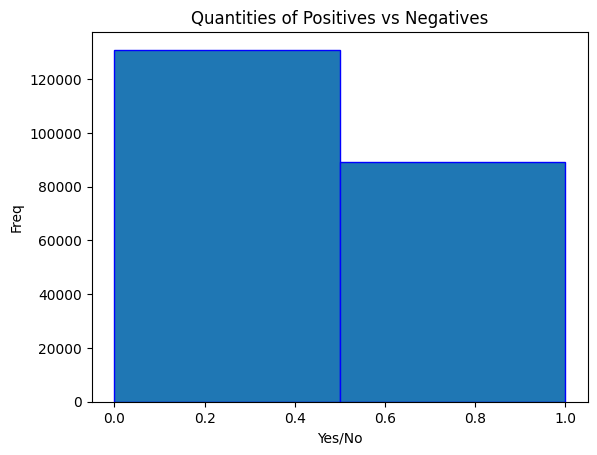

In [3]:
df1['label'].plot(kind='hist',bins=2,edgecolor='blue')
plt.title("Quantities of Positives vs Negatives")
plt.xlabel("Yes/No")
plt.ylabel("Freq")
plt.show()

From the graph, we can see that there are considerable quantities of positive and negative cases.

We also need to preprocess the graph data. We need to loop through all the images and convert them into treatable matrices; we need to make sure that there are no empty files or null values. Last but not least, we need to normalize the data by dividing the data by 255.

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# process all images and stock them in an array
sizeImg=(img.shape[0],img.shape[1])
listImgs=[]
for i, r in df1.iterrows():
    fichier=rep+r['id']+'.tif'
    listImgs.append(img_to_array(load_img(fichier, target_size=sizeImg))/255.0)
    if i %10000==0 and not i==0:
        print(i,"images have been processed")
    if i>50000:
        break

10000 images have been processed
20000 images have been processed
30000 images have been processed
40000 images have been processed
50000 images have been processed


Now that we have processed all the images, we can analyse the image matrices and visualize them using conventional data visualization tools. For example, we can isolate the three channels and explore possible patterns among them. Since there are too many images, let's only extract a small sample.

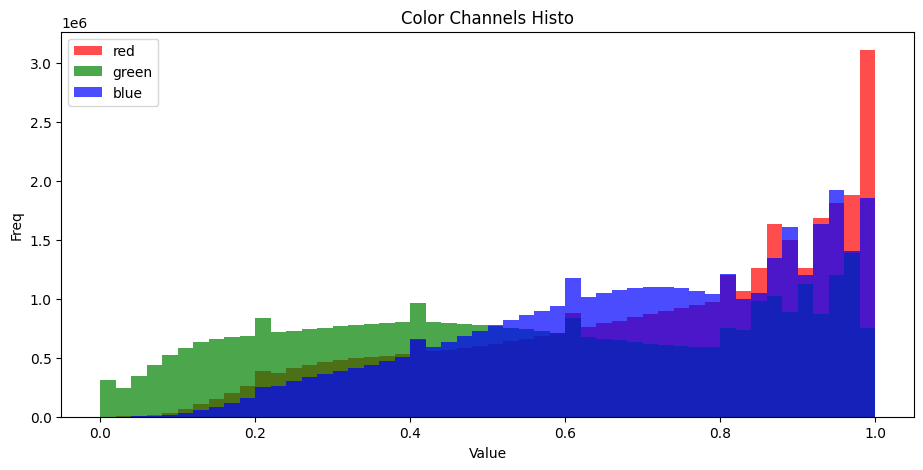

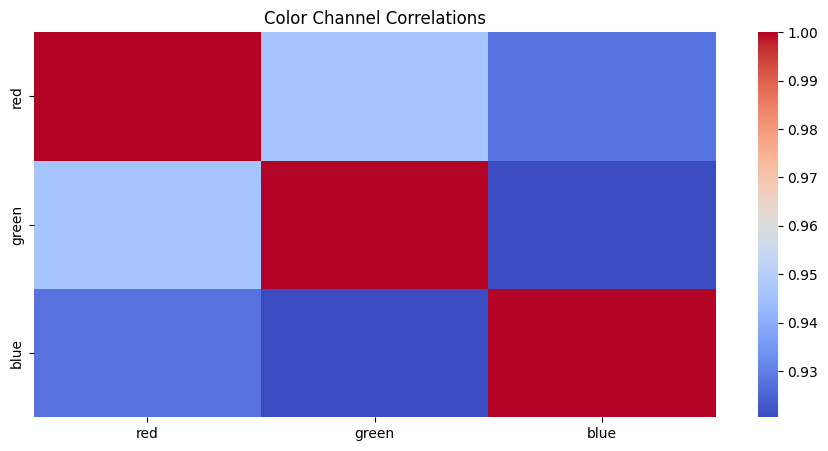

In [5]:
import seaborn as sns
colors=['red','green','blue']
values=[]

plt.figure(figsize=(11,5))
for i in range(len(colors)):
    values.append(np.concatenate([im[:,:,i].flatten() for im in listImgs[:4000]]))
    plt.hist(values[-1],bins=50,alpha=0.7,color=colors[i],label=colors[i])
plt.title('Color Channels Histo')
plt.xlabel('Value')
plt.ylabel('Freq')
plt.legend()
plt.show()


# correlation coefficient
values2=np.stack(values,axis=1)
covMat=np.corrcoef(values2,rowvar=False)
plt.figure(figsize=(11,5))
sns.heatmap(covMat,cmap='coolwarm',xticklabels=colors,yticklabels=colors)
plt.title('Color Channel Correlations')
plt.show()

From the above graph, we can see that red and blue dominate, which is why we see a purple tone in the sample picture. Additionally, green color tends to be low to medium in the images. From the correlation matrix shown as a heat map, we can observe that there is a high correlation between green and blue and a medium correlation between red and blue.

Now that we have all the graphical data in the form of matrices, we can separate the value of the labels, and then split the data into training set and validation set.

In [6]:
n=len(listImgs)
y=df1['label'].iloc[:n]
print(y.shape)

(50002,)


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

X_tr, X_v,y_tr,y_v = train_test_split(np.array(listImgs),y, test_size=0.2, random_state=42)
print(X_tr.shape,X_v.shape,y_tr.shape,y_v.shape)

(40001, 96, 96, 3) (10001, 96, 96, 3) (40001,) (10001,)


Now that we have the data, we can design a deep learning model. Recall that images are represented by huge matrices, so convolutions and pooling must be applied to reduce the features whilst taking into considerations hidden features in the pixels. We will apply the infrastructure taught in class, which is the structure of convolution-convolution-pooling followed by dense layers.

Filter size is set to be 3x3. The first reason for doing so is that those are the values that are often used in industry. For bigger inputs, sometimes, sizes such as 5x5 and 7x7 can be applied to the filters for some layers, but in our case, we will keep our filter size to be constantly 3x3.

As for the filter numbers, we decided to use the powers of 2 and we will use less filters in the beginning and more filters later on, because this corresponds to how machines learn features. Concretely, the machine capture a few simple features in the beginning and as the learning gets deeper, they are capable of identifying more features. We can adjust those values in our hyperparameter tuning step.

Activation function is chosent to be reLu for all the convolution layers and max pooling is preferred over average pooling. After convolution and pooling, we flatten the matrices into 1-D arrays before feeding them into the first dense layer to capture complex representations in the images. 

Finally, we feed the output from the previous dense layer to a dense layer having an output size of 1 and a sigmoid activation function, because this problem is a binary classification problem.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input
from tensorflow.keras.optimizers import RMSprop

model=Sequential()
model.add(Input(shape=(96, 96, 3)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer= RMSprop(learning_rate=0.001)
              , loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,335,841 (5.10 MB)

 Trainable params: 1,335,841 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

After the model is designed, we can now fit the data. Note that we can obtain the learning curve from model.fit, which helps us to understand how the learning is processed and see if there is overfit.

In [9]:
import time
print(X_tr.shape,X_v.shape,y_tr.shape,y_v.shape)
t1 = time.time()
hist=model.fit(X_tr, y_tr, validation_data=(X_v, y_v), epochs=20, batch_size=32)
dt = time.time()-t1
print(dt,"seconds")

(40001, 96, 96, 3) (10001, 96, 96, 3) (40001,) (10001,)
Epoch 1/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 900s 718ms/step - accuracy: 0.6872 - loss: 0.5939 - val_accuracy: 0.7935 - val_loss: 0.4889
Epoch 2/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 889s 710ms/step - accuracy: 0.8017 - loss: 0.4416 - val_accuracy: 0.6546 - val_loss: 0.9054
Epoch 3/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 895s 715ms/step - accuracy: 0.8257 - loss: 0.4052 - val_accuracy: 0.7937 - val_loss: 0.4862
Epoch 4/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 922s 715ms/step - accuracy: 0.8441 - loss: 0.3597 - val_accuracy: 0.8612 - val_loss: 0.3296
Epoch 5/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 922s 737ms/step - accuracy: 0.8658 - loss: 0.3242 - val_accuracy: 0.8655 - val_loss: 0.3358
Epoch 6/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 899s 719ms/step - accuracy: 0.8773 - loss: 0.3054 - val_accuracy: 0.6968 - val_loss: 0.6413
Epoch 7/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 893s 714ms/step - accuracy: 0.8806 - loss: 0.2921 - val_accuracy: 0.8322 - val_loss: 0.4321
Epoch 

The model has already a satisfactory accuracy; however, we want it to be better!

One thing we can do is that we can plot the learning curves for both the training set and the validation set, so that we can visualize the learning process, to see if there is overfit and if there is too much noise. If there is too much noise, we can try to adjust the optimizer by including a momentum or scheduling the learning rate.

313/313 - 56s - 179ms/step - accuracy: 0.8755 - loss: 0.5208
0.875512421131134 0.5208022594451904


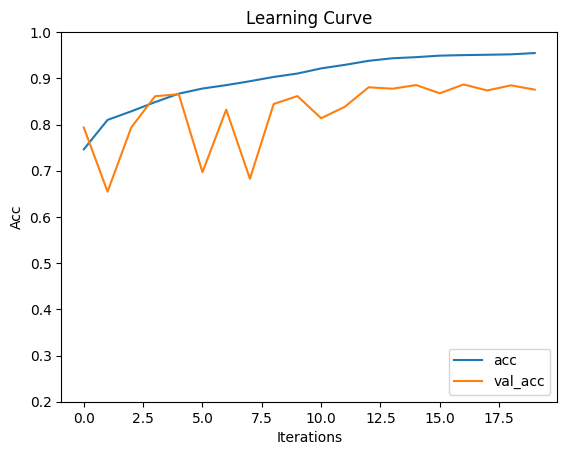

In [10]:
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label = 'val_acc')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Acc')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(X_v, y_v, verbose=2)
print(val_acc,val_loss)

As is shown in the graph above, there is little overfit (and it seems that the learning is almost complete at epochs=10) and there is a bit too much noise. We can optionally change the optimizer or include a recall to see how to leanring behaves; however, since the noise is not too much, it is not necessary to waste our time in this direction.

Another thing we can do is to tune the hyperparameters.

As is discussed above, a bigger filter size or a bigger stride might help to reduce feature dimensions; whereas, since there is no overfit, we can keep our filter size to 3x3.

Moreover, we can try to change the filter numbers in each layer or even add more layers to see how the learning behaves. Since we use powers of 2 to be the number of filters, we can move the powers of 2 up by 1 or down by 1, to see if the accuracy can be improved.

Last but not least, dropout rate and learning rate might be interesting to be played with. Since there is no apparent overfit, maybe we want to increase the learning rate a little bit and increase the dropout rate slightly to cushion potential overfit. Despite the fact that not many people do that, we can also change the activation functions to see if this makes a difference.

Noting that chaning n parameters will make us run the model multiple times; fortunately, we do not need to copy paste the code multiple times and we can actually use keras_tuner to tune our hyperparameters, by inputting the possibilities in lists in the same code. All filter sizes, output sizes, dropout rates and learning rates can be tuned. This step keeps failing because Kaggle runs out of memory; therefore, I commented some part of the code to make Kaggle work.

Alternatively, we can manually carry out hyperparameter tuning and run the code several times, even though it is very annoying since the code needs hours even after I reduced the size of the images.

In [11]:
import keras_tuner as kt

def buildModel(hp):
    model=Sequential()
    model.add(Input(shape=(96, 96, 3)))
    model.add(Conv2D(hp.Choice('filter1', [32 #, 64
                                          ]),(3,3),activation='relu'))
    model.add(Conv2D(hp.Choice('filter2', [32 #, 64
                                          ]),(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(hp.Choice('filter3', [#128
                                           #, 
                                            64
                                          ]),(3,3),activation='relu'))
    model.add(Conv2D(hp.Choice('filter4', [#128 , 
                                            64
                                          ]),(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer= RMSprop(learning_rate=hp.Choice('lr', [0.001#, 0.01
                                                                   ]))
                  , loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    buildModel,
    objective='val_accuracy',
    max_trials=10
)
tuner.search(
    X_tr, y_tr,
    epochs=10,
    validation_data=(X_v, y_v),
    batch_size=32
)

bestParams=tuner.get_best_hyperparameters(num_trials=1)[0]

print(bestParams.get('filter1'),
      bestParams.get('filter2'),
      bestParams.get('filter3'),
      bestParams.get('filter4'),
      bestParams.get('lr')
     )

Trial 1 Complete [02h 17m 45s]
val_accuracy: 0.8841115832328796

Best val_accuracy So Far: 0.8841115832328796
Total elapsed time: 02h 17m 45s
32 32 64 64 0.001


With the strategy explained above, we can tune our hyperparameters. With them, we can now train our best model and deliver it as our product.

In [12]:
bestM = tuner.hypermodel.build(bestParams)
val_loss, val_acc = bestM.evaluate(X_v, y_v, verbose=2)
print(val_acc,val_loss)

313/313 - 51s - 162ms/step - accuracy: 0.5896 - loss: 0.6888
0.5896410346031189 0.6888023018836975


As a conclusion, we obtained our best model. 

During the process of hyperparameter tuning, it was found that 3x3 is a proper filter size since 5x5 or 7x7 does not augment the accuracy and can even risk lowering the model accuracy. The proper filter sizes can be between 32 to 128, in ascending order for our convolution layers, since in this case, machine learning can go from simpler to more complicated, which corresponds to the usual way for machines to learn about features.

Due to machine performance restriction, I ran into timeout error thousands of times. To resolve this issue and be able to submit the project, I was forced to reduce the size of input and cut hyperparameter tuning process into smaller manual pieces. Despite the difficulties, we obtained a satisfactory model, which can be improved in the future.

To improve it, we can feed more data and perform more detailed hyperparameter tuning to obtain the optimal data. As is mentioned in the course, when performing graphic learning, sometimes, it is desirable to rotate the grpahs, translate them, or performing other linear transformations on them, to improve the learning outcome. I have not tried out those strategies while doing this project, but they definitely deserve to be tried out in the future.

Now for the submission, we make predictions and output them into a csv file.

In [13]:
"""df1 = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
rep=r'/kaggle/input/histopathologic-cancer-detection/test/'
listImgs=[]
for i, r in df1.iterrows():
    fichier=rep+r['id']+'.tif'
    listImgs.append(img_to_array(load_img(fichier, target_size=sizeImg))/255.0)

pred=bestM.predict(listImgs)
df2=pd.DataFrame({
    'id': df1['id'], 
    'label': pred.flatten()
})
df2.to_csv('/kaggle/working/pred_output.csv', index=False)

"""

"df1 = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')\nrep=r'/kaggle/input/histopathologic-cancer-detection/test/'\nlistImgs=[]\nfor i, r in df1.iterrows():\n    fichier=rep+r['id']+'.tif'\n    listImgs.append(img_to_array(load_img(fichier, target_size=sizeImg))/255.0)\n\npred=bestM.predict(listImgs)\ndf2=pd.DataFrame({\n    'id': df1['id'], \n    'label': pred.flatten()\n})\ndf2.to_csv('/kaggle/working/pred_output.csv', index=False)\n\n"